<a href="https://colab.research.google.com/github/LyMarco/Semantic-Mono-Depth/blob/master/Copy_of_Monodepth_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [0]:
# Look for Tesla P100-PCIE
# %%shell
!nvidia-smi

Tue Mar 31 07:27:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.72       Driver Version: 410.72       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Don't think we need this!
!pip install torch
!pip3 install torchvision

Defaulting to user installation because normal site-packages is not writeable
     |################################| 753.4 MB 11 kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
     |################################| 4.0 MB 4.8 MB/s 
     |################################| 2.1 MB 16.4 MB/s 


In [0]:
!git clone https://github.com/Po-Hsun-Su/pytorch-ssim.git
!mv pytorch-ssim/pytorch_ssim ./

fatal: could not create work tree dir 'pytorch-ssim': Permission denied
mv: cannot stat 'pytorch-ssim/pytorch_ssim': No such file or directory


In [0]:
pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [0]:
import torch.nn.functional as F
import os
import torch
import time
import random
from skimage import io, transform, color, data, img_as_float
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pytorch_ssim
import cv2

ImportError: ignored

##Building datasets 

In [0]:
# Download segment data
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip

--2020-03-31 06:31:37--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.73.139
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.73.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip.1’

data_semantics.zip.   6%[>                   ]  20.19M  2.95MB/s    eta 4m 10s 

KeyboardInterrupt: ignored

In [0]:
!unzip -l data_semantics.zip
!unzip data_semantics.zip -d ./images

Archive:  data_semantics.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  2018-04-12 10:51   testing/
        0  2018-04-12 10:51   testing/image_2/
   806490  2015-07-28 18:02   testing/image_2/000000_10.png
   770406  2015-07-28 18:01   testing/image_2/000001_10.png
   796968  2015-07-28 18:00   testing/image_2/000002_10.png
   813509  2015-07-28 18:03   testing/image_2/000003_10.png
   879739  2015-07-28 18:01   testing/image_2/000004_10.png
   908585  2015-07-28 18:00   testing/image_2/000005_10.png
   823373  2015-07-28 18:00   testing/image_2/000006_10.png
   850638  2015-07-28 18:01   testing/image_2/000007_10.png
   849318  2015-07-28 18:03   testing/image_2/000008_10.png
   855797  2015-07-28 18:03   testing/image_2/000009_10.png
   888203  2015-07-28 18:01   testing/image_2/000010_10.png
   909208  2015-07-28 18:00   testing/image_2/000011_10.png
   899108  2015-07-28 18:01   testing/image_2/000012_10.png
   885607  2015-07-28 18:02   testi

In [0]:
# Download KITTI 2015 Stereo dataset
# !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip
!unzip data_scene_flow.zip -d ./images/

Archive:  data_scene_flow.zip
replace ./images/training/disp_noc_1/000033_10.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: ./images/training/disp_noc_1/000033_10.png  
 extracting: ./images/training/disp_noc_1/000076_10.png  
 extracting: ./images/training/disp_noc_1/000194_10.png  
 extracting: ./images/training/disp_noc_1/000137_10.png  
 extracting: ./images/training/disp_noc_1/000110_10.png  
 extracting: ./images/training/disp_noc_1/000188_10.png  
 extracting: ./images/training/disp_noc_1/000015_10.png  
 extracting: ./images/training/disp_noc_1/000155_10.png  
 extracting: ./images/training/disp_noc_1/000128_10.png  
 extracting: ./images/training/disp_noc_1/000162_10.png  
 extracting: ./images/training/disp_noc_1/000144_10.png  
 extracting: ./images/training/disp_noc_1/000052_10.png  
 extracting: ./images/training/disp_noc_1/000121_10.png  
 extracting: ./images/training/disp_noc_1/000193_10.png  
 extracting: ./images/training/disp_noc_1/000171_10.png  
 extract

In [0]:
%%shell

cd 'images/training/image_2'

for name in *_11.png
do
    rm $name
done

In [0]:
%%shell

cd 'images/training/image_3'

for name in *_11.png
do
    rm $name
done

##Load Dataset

In [0]:
class DispSegDataset(Dataset):
    """Dataset for left-right images, disparity and segmentation maps."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with folders 'input' and 'depth_maps'.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.left_dir = os.path.join(self.root_dir, 'image_2/*')
        self.right_dir = os.path.join(self.root_dir, 'image_3/*')
        self.disp_left_dir = os.path.join(self.root_dir, 'disp_occ_0/*')
        self.disp_right_dir = os.path.join(self.root_dir, 'disp_occ_1/*')
        self.semantic_dir = os.path.join(self.root_dir, 'semantic/*')

        self.left = io.imread_collection(self.left_dir)
        self.right = io.imread_collection(self.right_dir)
        self.disp_left = io.imread_collection(self.disp_left_dir)
        self.disp_right = io.imread_collection(self.disp_right_dir)
        self.semantic = io.imread_collection(self.semantic_dir)

    def __len__(self):
      return len(self.left)
      # return 1
      
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        item = {'left': self.left[idx], 'right': self.right[idx], 
                'disp_left': self.disp_left[idx], 'disp_right': self.disp_right[idx],
                'semantic': self.semantic[idx]}
        if self.transform:
            item = self.transform(item)
            
            
        return item

In [0]:
# Data Transformations
# Rescale object repurposed from Pytorch tutorial on Datasets by Sasank Chilamkurthy
class RescaleDispSeg(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        left, right, disp_l, disp_r, semantic = sample['left'], sample['right'], sample['disp_left'], sample['disp_right'], sample['semantic']

        h, w = left.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        left = transform.resize(left, (new_h, new_w))
        right = transform.resize(right, (new_h, new_w))
        disp_l = transform.resize(disp_l, (new_h, new_w))
        disp_r = transform.resize(disp_r, (new_h, new_w))
        semantic = transform.resize(semantic, (new_h, new_w))

        return {'left': left, 'right': right, 'disp_left':disp_l, 'disp_right':disp_r, 'semantic':semantic}

In [0]:
# Load the datasest
data_path = "./images/"

#Original scale is 1242x375
scale = RescaleDispSeg((256, 512))

train_dir = os.path.join(data_path, 'training')
# test_dir = os.path.join(data_path, 'testing')

depth_train_full = DispSegDataset(train_dir, scale)

200


(<matplotlib.axes._subplots.AxesSubplot at 0x7f11296040b8>,
 <matplotlib.image.AxesImage at 0x7f1129568860>)

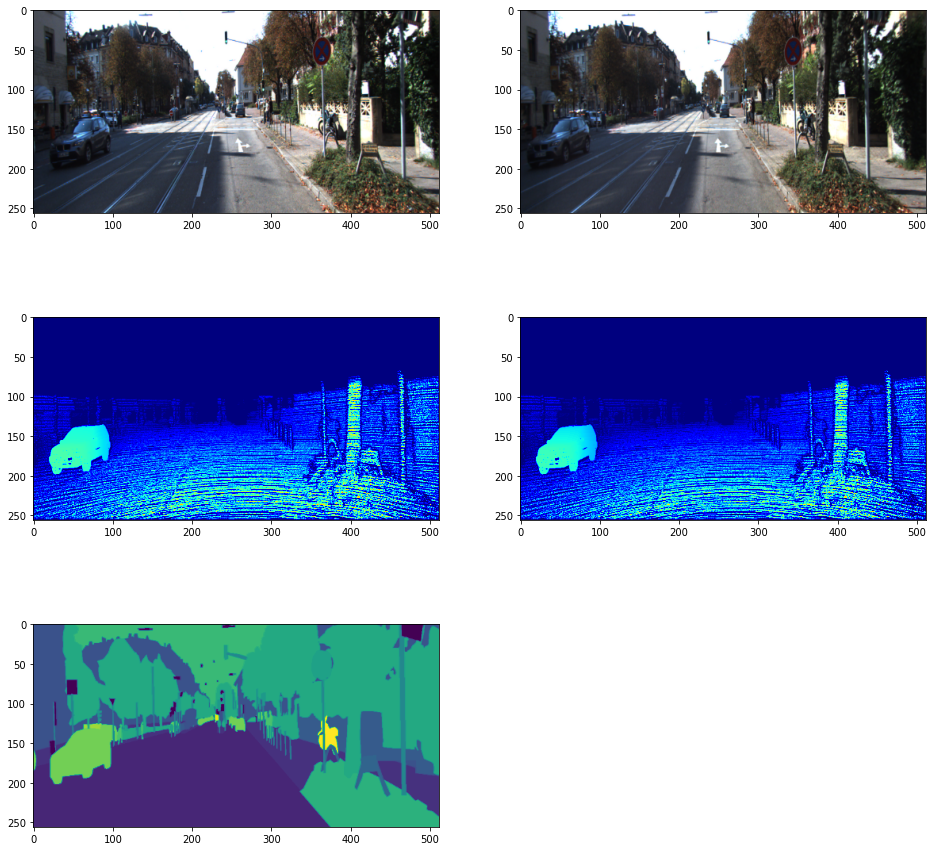

In [0]:
# Test the dataset is working
print(len(depth_train_full))
k = 1
plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 1), plt.imshow(depth_train_full[k]['left'])
plt.subplot(3, 2, 2), plt.imshow(depth_train_full[k]['right'])
plt.subplot(3, 2, 3), plt.imshow(depth_train_full[k]['disp_left'], cmap='jet')
plt.subplot(3, 2, 4), plt.imshow(depth_train_full[k]['disp_right'], cmap='jet')
plt.subplot(3, 2, 5), plt.imshow(depth_train_full[k]['semantic'])

#Model

In [0]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, num_filters, kernel):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, num_filters, kernel_size=kernel, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_filters, num_filters, kernel_size=kernel, padding=1),
            nn.ReLU(),)
        
    def forward(self, x):
        return self.conv(x)

In [0]:
class UpConv(nn.Module):
    def __init__(self, in_channels, num_filters, kernel):
        super(UpConv, self).__init__()
        # self.conv = nn.Sequential(
        #     nn.Upsample(scale_factor=2),
        #     nn.Conv2d(in_channels, num_filters, kernel_size=kernel, padding=2) 
        #     ,)
        self.conv = nn.ConvTranspose2d(in_channels, num_filters, 
              kernel_size=kernel, stride=2, 
              padding=1, output_padding=1)
    
    def forward(self, x):
        return self.conv(x)

In [0]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, num_features, num_seg_classes):
        super(UNet, self).__init__()
        self.encode1 = nn.Sequential(
            nn.Conv2d(3, num_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features),
            nn.ReLU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features),
            nn.ReLU()
        )
        self.encode2 = nn.Sequential(
            nn.Conv2d(num_features, num_features * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features * 2),
            nn.ReLU(),
            nn.Conv2d(num_features * 2, num_features * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features * 2),
            nn.ReLU())
        self.encode3 = nn.Sequential(
            nn.Conv2d(num_features * 2, num_features * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features * 4),
            nn.ReLU(),
            nn.Conv2d(num_features * 4, num_features * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features * 4),
            nn.ReLU(),
        )
        self.encode4 = nn.Sequential(
            nn.Conv2d(num_features * 4, num_features * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features * 8),
            nn.ReLU(),
            nn.Conv2d(num_features * 8, num_features * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features * 8),
            nn.ReLU(),
        )

        self.encode5 = nn.Sequential(
            nn.Conv2d(num_features * 8, num_features * 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*16),
            nn.ReLU(),
            nn.Conv2d(num_features * 16, num_features * 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*16),
            nn.ReLU(),
            nn.ConvTranspose2d(num_features * 16, num_features * 8, kernel_size=2, stride=2)
        )

        self.decode1D = nn.Sequential(
            nn.Conv2d(num_features * 16, num_features * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*8),
            nn.ReLU(),
            nn.Conv2d(num_features * 8, num_features * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*8),
            nn.ReLU(),
            nn.ConvTranspose2d(num_features * 8, num_features * 4, kernel_size=2, stride=2)
        )
        self.decode2D = nn.Sequential(
            nn.Conv2d(num_features * 8, num_features * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*4),
            nn.ReLU(),
            nn.Conv2d(num_features * 4, num_features * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*4),
            nn.ReLU(),
            nn.ConvTranspose2d(num_features * 4, num_features * 2, kernel_size=2, stride=2)
        )
        self.decode3D = nn.Sequential(
            nn.Conv2d(num_features * 4, num_features * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*2),
            nn.ReLU(),
            nn.Conv2d(num_features * 2, num_features * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*2),
            nn.ReLU(),
            nn.ConvTranspose2d(num_features * 2, num_features, kernel_size=2, stride=2)
        )
        self.decode4D = nn.Sequential(
            nn.Conv2d(num_features * 2, num_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features),
            nn.ReLU(), 
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features),
            nn.ReLU(),
        )
                
        self.disp = nn.Sequential(
            nn.Conv2d(num_features, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid(),)
        

        self.decode1S = nn.Sequential(
            nn.Conv2d(num_features * 16, num_features * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*8),
            nn.ReLU(),
            nn.Conv2d(num_features * 8, num_features * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*8),
            nn.ReLU(),
            nn.ConvTranspose2d(num_features * 8, num_features * 4, kernel_size=2, stride=2)
        )
        self.decode2S = nn.Sequential(
            nn.Conv2d(num_features * 8, num_features * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*4),
            nn.ReLU(),
            nn.Conv2d(num_features * 4, num_features * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*4),
            nn.ReLU(),
            nn.ConvTranspose2d(num_features * 4, num_features * 2, kernel_size=2, stride=2)
        )
        self.decode3S = nn.Sequential(
            nn.Conv2d(num_features * 4, num_features * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*2),
            nn.ReLU(),
            nn.Conv2d(num_features * 2, num_features * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features*2),
            nn.ReLU(),
            nn.ConvTranspose2d(num_features * 2, num_features, kernel_size=2, stride=2)
        )
        self.decode4S = nn.Sequential(
            nn.Conv2d(num_features * 2, num_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features),
            nn.ReLU(), 
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features),
            nn.ReLU(),
        )
        self.seg = nn.Conv2d(num_features, num_seg_classes, kernel_size=kernel, padding=1)



    def forward(self, x):
        # print("HOLLy", x)
        # Encoder
        encode1 = self.encode1(x)
        encode1_out = F.max_pool2d(encode1, kernel_size=2)
        
        encode2 = self.encode2(encode1_out)
        encode2_out = F.max_pool2d(encode2, kernel_size=2)


        encode3 = self.encode3(encode2_out)
        encode3_out = F.max_pool2d(encode3, kernel_size=2)

        encode4 = self.encode4(encode3_out)
        encode4_out = F.max_pool2d(encode4, kernel_size=2)

        encode5_out = self.encode5(encode4_out)

        # Decoder Depth
        decode1_input = torch.cat([encode4, encode5_out], dim=1)
        decode1 =  self.decode1D(decode1_input)

        decode2_input = torch.cat([decode1, encode3], dim=1)
        decode2 =  self.decode2D(decode2_input)

        decode3_input = torch.cat([decode2, encode2], dim=1)
        decode3 =  self.decode3D(decode3_input)
        
        decode4_input = torch.cat([decode3, encode1], dim=1)
        decode4 =  self.decode4D(decode4_input)
        self.out_disp = self.disp(decode4)

        # Decoder semantic
        decode1_input = torch.cat([encode4, encode5_out], dim=1)
        decode1 =  self.decode1S(decode1_input)

        decode2_input = torch.cat([decode1, encode3], dim=1)
        decode2 =  self.decode2S(decode2_input)

        decode3_input = torch.cat([decode2, encode2], dim=1)
        decode3 =  self.decode3S(decode3_input)
        
        decode4_input = torch.cat([decode3, encode1], dim=1)
        decode4 =  self.decode4S(decode4_input)
        # Both towers
        self.out_seg = self.seg(decode4)

        return self.out_disp, self.out_seg

In [0]:
class UNet_Double(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, num_filters, num_seg_classes):
        super(UNet_Double, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2)
        
        self.conv1 = DoubleConv(in_channels, num_filters, kernel)
        self.conv2 = DoubleConv(num_filters, num_filters*2, kernel)
        self.conv3 = DoubleConv(num_filters*2, num_filters*4, kernel)

        self.acrossconv = DoubleConv(num_filters*4, num_filters*8, kernel)
        
        self.upconv1 = UpConv(num_filters*8, num_filters*4, kernel)
        self.conv5 = DoubleConv(num_filters*8, num_filters*4, kernel)
        self.upconv2 = UpConv(num_filters*4, num_filters*2, kernel)
        self.conv6 = DoubleConv(num_filters*4, num_filters*2, kernel)
        self.upconv3 = UpConv(num_filters*2, num_filters, kernel)
        self.conv7 = DoubleConv(num_filters*2, num_filters, kernel)
      
        self.disp = nn.Sequential(
            nn.Conv2d(num_filters, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid(),)

        self.seg = nn.Conv2d(num_filters, num_seg_classes, kernel_size=kernel, padding=1)
        
    def forward(self, x):
        print(x)
        # Encoder
        self.out1 = self.conv1(x)
        self.out1max = self.maxpool(self.out1)
        self.out2 = self.conv2(self.out1max)
        self.out2max = self.maxpool(self.out2)
        self.out3 = self.conv3(self.out2max)
        self.out3max = self.maxpool(self.out3)

        self.rf = self.acrossconv(self.out3max)

        # Disparity decoder
        self.up1 = self.upconv1(self.rf)
        self.out5 = self.conv5(torch.cat((self.up1, self.out3), 1))
        self.up2 = self.upconv2(self.out5)
        self.out6 = self.conv6(torch.cat((self.up2, self.out2), 1))
        self.up3 = self.upconv3(self.out6)
        self.out7 = self.conv7(torch.cat((self.up3, self.out1), 1))
        self.out_disp = self.disp(self.out7)

        # Segmentation decoder
        self.up1seg = self.upconv1(self.rf)
        self.out5seg = self.conv5(torch.cat((self.up1seg, self.out3), 1))
        self.up2seg = self.upconv2(self.out5)
        self.out6seg = self.conv6(torch.cat((self.up2seg, self.out2), 1))
        self.up3seg = self.upconv3(self.out6)
        self.out7seg = self.conv7(torch.cat((self.up3seg, self.out1), 1))
        self.out_seg = self.seg(self.out7seg)
          
        return self.out_disp, self.out_seg


# Training

In [0]:
# Loss Functions

a_d = 1.0
a_s = 0.1
gamma = 0.85

def SSIM_loss(x, y):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2 

    mu_x = F.avg_pool2d(x, 3, 1, 1)
    mu_y = F.avg_pool2d(y, 3, 1, 1)

    sigma_x  = F.avg_pool2d(x ** 2, 3, 1, 1) - mu_x ** 2
    sigma_y  = F.avg_pool2d(y ** 2, 3, 1, 1) - mu_y ** 2
    sigma_xy = F.avg_pool2d(x * y , 3, 1, 1) - mu_x * mu_y

    SSIM_n = (2. * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    SSIM_d = (mu_x ** 2. + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)

    SSIM = SSIM_n / SSIM_d

    return torch.clamp((1. - SSIM) / 2, 0, 1)


def depth_loss(out_disp, out_sem, target_disp_l, target_disp_r, target_sem):
    # SSIM = pytorch_ssim.SSIM(window_size=11)
    L1 = torch.nn.L1Loss(size_average=False, reduce=False)

    sim_left = torch.mean(1.0 - SSIM_loss(out_disp, target_disp_l)) / 2.0
    sim_right = torch.mean(1.0 - SSIM_loss(out_disp, target_disp_r)) / 2.0

    pixel_loss_l = torch.mean(L1(out_disp, target_disp_l))
    pixel_loss_r = torch.mean(L1(out_disp, target_disp_r))
    # print(pixel_loss.shape)

    left_loss = gamma * sim_left + (1. - gamma) * pixel_loss_l
    right_loss = gamma * sim_right + (1.- gamma) * pixel_loss_r
    # print("loss", left_loss, right_loss)
    # print("L1", pixel_loss_l)
    # print("SIM", sim_left)
    return left_loss + right_loss


def sem_loss(out_disp, out_sem, target_disp_l, target_disp_r, target_sem):
    CE = nn.CrossEntropyLoss()
    return CE(out_sem, target_sem) 


def total_loss(out_disp, out_sem, target_disp_l, target_disp_r, target_sem):
    d_ap = depth_loss(out_disp, out_sem, target_disp_l, target_disp_r, target_sem)
    d_sem = sem_loss(out_disp, out_sem, target_disp_l, target_disp_r, target_sem)
    return a_d * d_ap + a_s * d_sem


def bce(out_disp, out_sem, target_disp_l, target_disp_r, target_sem):
    BCE = nn.BCELoss()
    return BCE(out_disp, target_disp_l)


In [0]:
def validation(model, criterion, testdata, device):
    losses = []

    for i_batch, test_sample in enumerate(testdata):
        images = test_sample['image']
        masks = test_sample['map']
        
        reshaped_images = np.transpose(images, (0, 3, 1, 2))
        reshaped_masks = np.reshape(masks, (-1, 1, 256, 512))
    
        reshaped_images = reshaped_images.to(device)
        reshaped_masks = reshaped_masks.to(device)

        output = model(reshaped_images)

        loss = criterion(output, reshaped_masks)
        losses.append(loss.data.item())

    val_loss = np.mean(losses)
    return val_loss

In [0]:
# Main training loop

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args):
    torch.set_num_threads(5)

    # np.random.seed(args.seed)

    # DATALOADERS
    trainloader = torch.utils.data.DataLoader(args.train_data, batch_size=args.batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(args.test_data, batch_size=args.batch_size, shuffle=True)
    
    # MODEL
    num_in_channels = 1 if not args.downsize_input else 3
    model = UNet(in_channels=num_in_channels, out_channels=1, kernel=args.kernel, num_features=args.num_filters, num_seg_classes=6)
    # model = UNet_Double(in_channels=num_in_channels, out_channels=1,
    #           kernel=args.kernel, num_filters=args.num_filters, num_seg_classes=6)


    # LOSS FUNCTION
    if args.loss == "DEPTH-SEG":
        criterion = total_loss
    elif args.loss == "DEPTH":
        criterion = depth_loss
    elif args.loss == "SEG":
        criterion = sem_loss
    elif args.loss == "BCE":
        criterion = bce
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=args.learn_rate)

    # Train the model
    print("Beginning training ...")
    if args.gpu and torch.cuda.is_available(): 
        device = torch.device("cuda")
        model.cuda()
    else:
        device = torch.device("cpu")
      
    start = time.time()

    train_losses = []
    val_losses = []
    valid_accs = []

    model.train() # Change model to 'train' mode
    model.double()
        
    for epoch in range(args.epochs):
        # Train the Model
        losses = []

        # Forward + Backward + Optimize
        for i_batch, sample_batched in enumerate(trainloader):
            optimizer.zero_grad()

            left = sample_batched['left']
            right = sample_batched['right']
            disp_left = sample_batched['disp_left']
            disp_right = sample_batched['disp_right']
            semantic = sample_batched['semantic']

            # Reshape NHWC
            reshaped_left = np.transpose(left, (0, 3, 1, 2))
            reshaped_right = np.transpose(right, (0, 3, 1, 2))
            # Not sure about these 
            reshaped_disp_left = np.reshape(disp_left, (-1, 1, 256, 512))
            reshaped_disp_right = np.reshape(disp_right, (-1, 1, 256, 512))
            reshaped_sem = np.reshape(semantic, (-1, 1, 256, 512))

            reshaped_left = reshaped_left.to(device)
            reshaped_right = reshaped_right.to(device)
            reshaped_disp_left = reshaped_disp_left.to(device)
            reshaped_disp_right = reshaped_disp_right.to(device)
            reshaped_sem = reshaped_sem.to(device)

            # print(reshaped_left)
            model_disp, model_semantic = model(reshaped_left)
            # print(model_output.shape)
            loss = criterion(model_disp, model_semantic, reshaped_disp_left, reshaped_disp_right, reshaped_sem)
            # print("loss", loss, sample_batched)
            loss.backward()
            optimizer.step()

            losses.append(loss.data.item())
        else:
            avg_loss = np.mean(losses)
            train_losses.append(avg_loss)
            time_elapsed = time.time() - start
            
            model.eval()
            # val_loss = validation(model, criterion, testloader, device)
            val_loss = 0
            
            val_losses.append(val_loss)
            print('Epoch [%d/%d], Loss: %.4f, Val Loss: %.4f,  Time (s): %d' % (
                epoch+1, args.epochs, avg_loss, val_loss, time_elapsed))
            
            
    # Plot training curve
    plt.figure(figsize=(10, 8))
    plt.plot(train_losses, "b-", label="Training")
    plt.plot(val_losses, "r-", label="Validation")
    plt.legend()
    plt.title("Performance")
    plt.xlabel("Epochs")
    return model

In [0]:
# Arguments for training
args = AttrDict()
args_dict = {
              'gpu':True, 
              'loss':"DEPTH", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':4, 
              'epochs':40, 
              'seed':0,
              'downsize_input':True,
              'train_data':depth_train_full,
              'test_data':depth_train_full,
}
args.update(args_dict)
unet_depth = train(args)

Beginning training ...


RuntimeError: ignored

## Custom training loop

Trains a model for several epochs at a time

In [0]:
# Debug training loop - Trains a model for several epochs at a time

def debug_train(model, device, criterion, optimizer, epochs, prev_epochs, graph):
    
    # Train the model
    print("Beginning training ...")

    start = time.time()
    train_losses = []
    val_losses = []
    valid_accs = []
    for epoch in range(epochs):
        # Train the Model
        model.train() # Change model to 'train' mode
        model.double()
        
        losses = []

        # Forward + Backward + Optimize
        for i_batch, sample_batched in enumerate(trainloader):
            optimizer.zero_grad()

            left = sample_batched['left']
            right = sample_batched['right']
            disp_left = sample_batched['disp_left']
            disp_right = sample_batched['disp_right']
            semantic = sample_batched['semantic']

            # Reshape NHWC
            reshaped_left = np.transpose(left, (0, 3, 1, 2))
            reshaped_right = np.transpose(right, (0, 3, 1, 2))
            # Not sure about these 
            reshaped_disp_left = np.reshape(disp_left, (-1, 1, 256, 512))
            reshaped_disp_right = np.reshape(disp_right, (-1, 1, 256, 512))
            reshaped_sem = np.reshape(semantic, (-1, 1, 256, 512))

            reshaped_left = reshaped_left.to(device)
            reshaped_right = reshaped_right.to(device)
            reshaped_disp_left = reshaped_disp_left.to(device)
            reshaped_disp_right = reshaped_disp_right.to(device)
            reshaped_sem = reshaped_sem.to(device)

            model_disp, model_semantic = model(reshaped_left)
            
            loss = criterion(model_disp, model_semantic, reshaped_disp_left, reshaped_disp_right, reshaped_sem)
            loss.backward()
            optimizer.step()

            losses.append(loss.data.item())
        
            
        avg_loss = np.mean(losses)
        model.eval()
        # val_loss = validation(model, criterion, testloader, device)
        val_loss = 0

        train_losses.append(avg_loss)
        val_losses.append(val_loss)

        # if epoch == epochs-1:
        print('Epoch [%d/%d], Loss: %.4f, Val Loss: %.4f, Time: %ds' % (
              epoch+1+prev_epochs, epochs+prev_epochs, avg_loss, val_loss, time.time() - start))

    # Plot training curve
    plt.figure(figsize=(10, 8))
    plt.plot(train_losses, "b-", label="Training")
    plt.plot(val_losses, "r-", label="Validation")
    plt.legend()
    plt.title(graph)
    plt.xlabel("Epochs")

    print('Trained Network on [%d] total epochs thus far' % (epochs + prev_epochs))

    return model

In [0]:
args_dict = {
              'gpu':True,  
              'kernel':3,
              'num_filters':16, 
              'learn_rate':0.0001, 
              'batch_size':4, 
              'seed':0,
              'train_data':depth_train_full,
              'test_data':depth_train_full,
}

torch.set_num_threads(5)
np.random.seed(args_dict['seed'])

trainloader = torch.utils.data.DataLoader(args_dict['train_data'], batch_size=args_dict['batch_size'], shuffle=True)
testloader = torch.utils.data.DataLoader(args_dict['test_data'], batch_size=args_dict['batch_size'], shuffle=True)
    

# MODEL
num_in_channels = 1 if not args.downsize_input else 3
segnet = UNet_Double(in_channels=num_in_channels, out_channels=1,
          kernel=args.kernel, num_filters=args.num_filters, num_seg_classes=6)

# LOSS
criterion = depth_loss

optimizer = torch.optim.Adam(segnet.parameters(), lr=args_dict['learn_rate'])

device = torch.device("cuda")

segnet.cuda();

Beginning training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [1/10], Loss: 0.5916, Val Loss: 0.0000, Time: 0s
Epoch [2/10], Loss: 0.5915, Val Loss: 0.0000, Time: 0s
Epoch [3/10], Loss: 0.5915, Val Loss: 0.0000, Time: 0s
Epoch [4/10], Loss: 0.5915, Val Loss: 0.0000, Time: 1s
Epoch [5/10], Loss: 0.5915, Val Loss: 0.0000, Time: 1s
Epoch [6/10], Loss: 0.5915, Val Loss: 0.0000, Time: 1s
Epoch [7/10], Loss: 0.5914, Val Loss: 0.0000, Time: 1s
Epoch [8/10], Loss: 0.5914, Val Loss: 0.0000, Time: 2s
Epoch [9/10], Loss: 0.5914, Val Loss: 0.0000, Time: 2s
Epoch [10/10], Loss: 0.5914, Val Loss: 0.0000, Time: 2s
Trained Network on [10] total epochs thus far


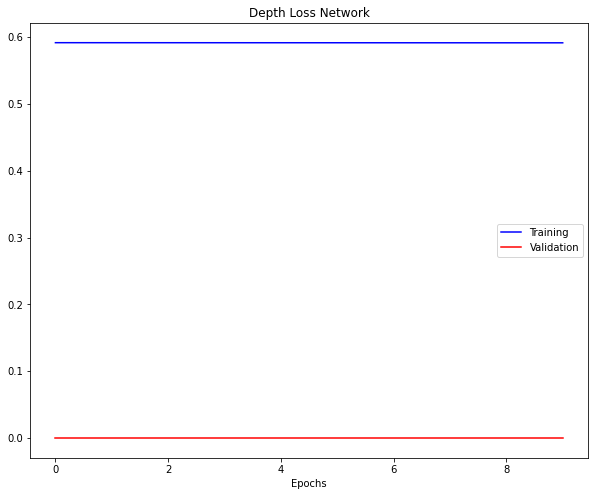

In [0]:
segnet = debug_train(segnet, device, criterion, optimizer, 10, 0, "Depth Loss Network")

#Evaluation

In [0]:
# Display a model's outputs against a dataset
def display(i, data, network):
    sample = data[i]
    device = torch.device("cuda")
    plt.subplot(2, 3, 1), plt.imshow(sample['left'])
    item = sample['left']
    re_item = np.transpose(item, (2, 0, 1))
    re_item = np.reshape(re_item, (-1, 3, 256, 512))
    re_item = torch.from_numpy(re_item).to(device)

    model_disp, model_semantic = network(re_item)
    model_disp_detached = model_disp.cpu().detach().numpy()
    model_sem_detached = model_semantic.cpu().detach().numpy()

    disp_result = model_disp_detached[0, 0]
    sem_result = model_sem_detached[0, 0]

    plt.subplot(2, 3, 2), plt.imshow(sample['disp_left'], cmap='gray')
    plt.subplot(2, 3, 3), plt.imshow(disp_result, cmap='gray')
    # print(disp_result)
    plt.subplot(2, 3, 4), plt.imshow(sample['semantic'])
    plt.subplot(2, 3, 5), plt.imshow(sem_result)

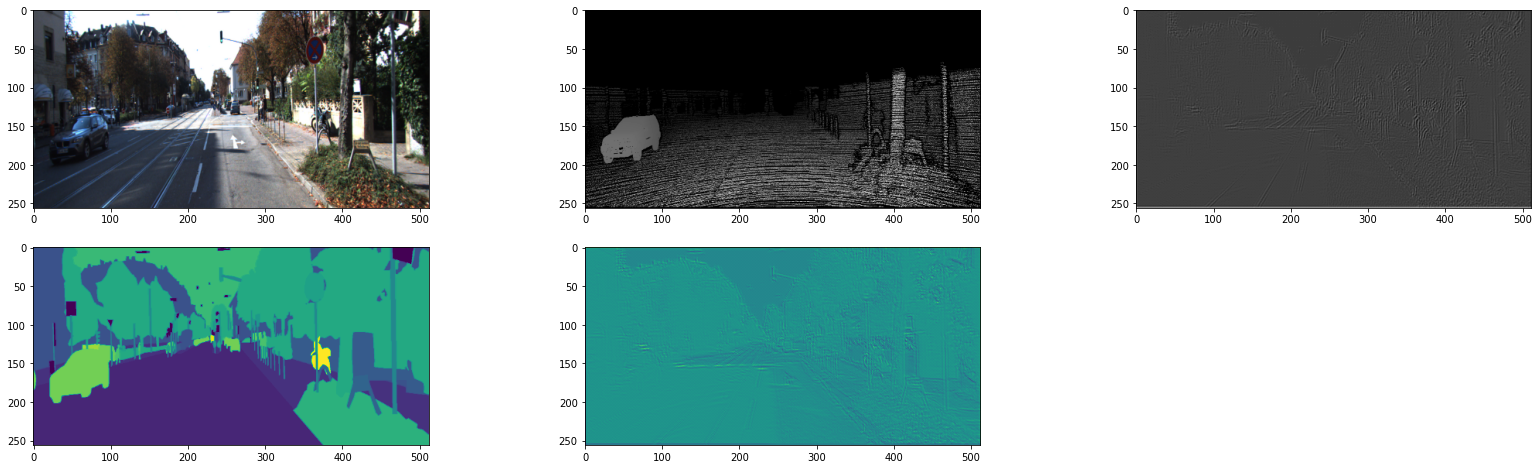

In [0]:
plt.figure(figsize=(28, 8))
display(1, depth_train_full, segnet)

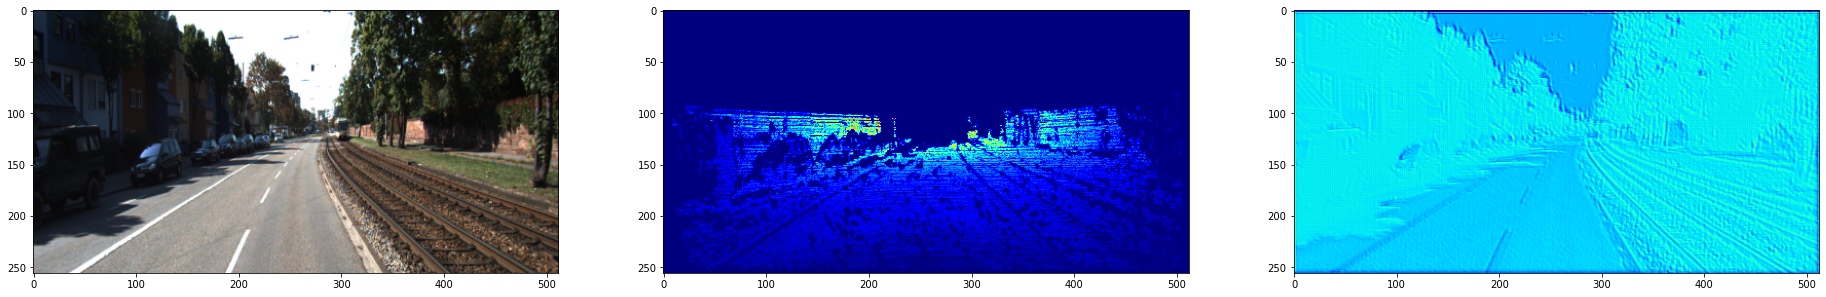

In [0]:
plt.figure(figsize=(32, 22))
display(5, depth_train, unet_depth)

In [0]:
# torch.save(unet, 'unet_base_1.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DoubleConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UpConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
